In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from glob import glob
import yaml

In [2]:
with open("../config.yaml", "r") as file:
    config = yaml.safe_load(file)


In [3]:
labels = glob("../label/*.json")
labels.sort()

In [4]:
# Read the json file
with open(labels[-1]) as f:
    data = json.load(f)
    print(f)

<_io.TextIOWrapper name='../label/project-4-at-2024-04-05-09-56-232d5a4d.json' mode='r' encoding='UTF-8'>


In [5]:
entities = []
relations = []
sent_entities = []
sent_relations = []

for sentence in data:
    t_entities = []
    t_relations = []
    for annotation in sentence["annotations"][0]["result"]:
        if annotation["type"] == "labels":
            entities.append(annotation["value"]["labels"][0])
            t_entities.append(annotation["value"]["labels"][0])
        elif annotation["type"] == "relation":
            relations.append(annotation["labels"])
    sent_entities.append(list(set(t_entities)))
 #   sent_relations.append(list(set(relations)))

In [6]:
relations = [item for items in relations for item in items]
#entities = [item for items in entities for item in items]
sent_entities = [item for items in sent_entities for item in items]

In [7]:
pd.DataFrame(sent_entities).value_counts()

0         
STRAIN        2294
ORGANISM       958
METABOLITE     868
EFFECT         775
PROTEIN        709
SPECIES        660
COMPOUND       494
ISOLATE        483
PHENOTYPE      378
MEDIUM         339
DISEASE        280
GENE           271
GENUS          177
MORPHOLOGY     160
VIRUS           98
ASSEMBLY         7
Name: count, dtype: int64

In [8]:
ner_df = pd.DataFrame(sent_entities).value_counts().reset_index().rename(columns={0:"ner", "count":"count_per_sentence"})

Text(0.5, 1.0, 'Number of sentences with entity')

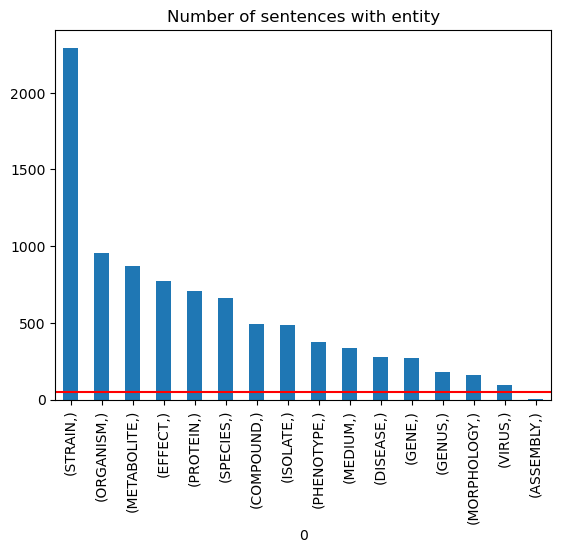

In [9]:
pd.DataFrame(sent_entities).value_counts().plot(kind='bar')
plt.axhline(50, color='red')
plt.title('Number of sentences with entity')

In [10]:
ner_df = ner_df.merge(pd.DataFrame(entities).value_counts().reset_index().rename(columns={0:"ner", "count":"count_per_entity"}))


Text(0.5, 1.0, 'Total number of entities')

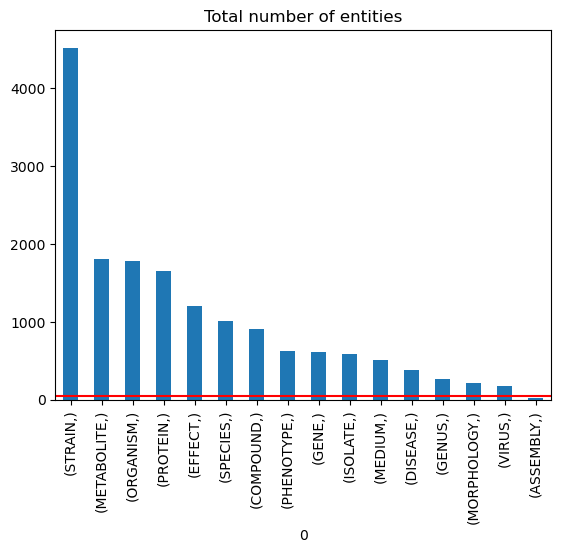

In [11]:
pd.DataFrame(entities).value_counts().plot(kind='bar')
plt.axhline(50, color='red')
plt.title('Total number of entities')

In [12]:
ner_df_m = ner_df.melt("ner", var_name="type", value_name="count")

In [13]:
ner_df_m

,ner,type,count
0,STRAIN,count_per_sentence,2294
1,ORGANISM,count_per_sentence,958
2,METABOLITE,count_per_sentence,868
3,EFFECT,count_per_sentence,775
4,PROTEIN,count_per_sentence,709
5,SPECIES,count_per_sentence,660
6,COMPOUND,count_per_sentence,494
7,ISOLATE,count_per_sentence,483
8,PHENOTYPE,count_per_sentence,378
9,MEDIUM,count_per_sentence,339


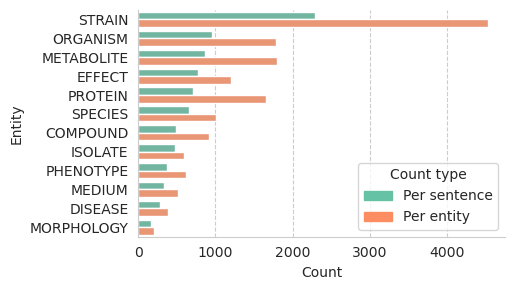

In [14]:
import matplotlib.patches as mpatches

# Define the colors for the legend
colors = ["#66c2a5", "#fc8d62"]

# Create the patches for the legend
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, ["Per sentence", "Per entity"])]

# Set the style to show faint vertical grid lines
sns.set_style("whitegrid", {"axes.grid": True, "grid.linestyle": "--", "grid.alpha": 0.3})

# Plot the graph
sns.catplot(y="ner", x="count", hue="type", kind="bar", data=ner_df_m[ner_df_m["ner"].isin(config["ner_labels"])], palette="Set2", legend=False, height=3, aspect=1.75)
plt.xlabel("Count")
plt.ylabel("Entity")
plt.legend(handles=patches, title="Count type")

plt.savefig("./figures/predictions/labeled_entities_counts.pdf")

### RELS

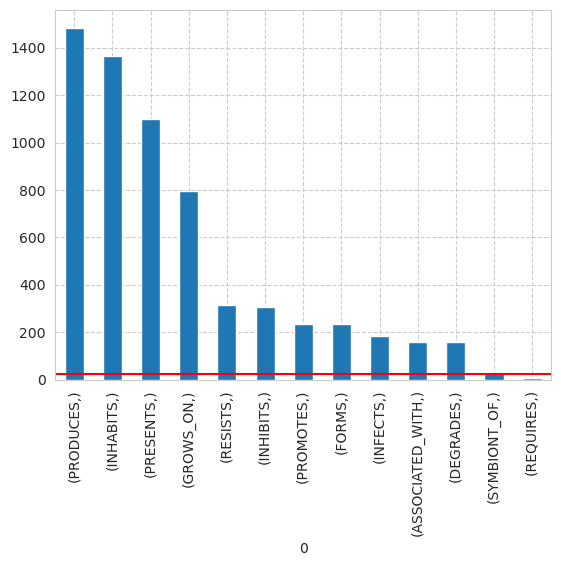

In [15]:
pd.DataFrame(relations).value_counts().plot(kind='bar')
plt.axhline(25, color='red')

In [16]:
sentence_id = []
sentence_text = []
relationships = []
for sentence in data:
    ids = {} # id -> label dictionary
    for annotation in sentence["annotations"][0]["result"]:
        if annotation["type"] == "labels":
            ids[annotation["id"]] = annotation["value"]["labels"]
#            text[annotation["id"]] = annotation["value"]["text"]
        elif annotation["type"] == "relation":
#            print(ids.get(annotation["from_id"]),"->", ids.get(annotation["to_id"]), ":", annotation["labels"])
            s = str(*ids.get(annotation["from_id"]))+"->"+ str(*ids.get(annotation["to_id"]))+ ":"+ str(*annotation["labels"])
            relationships.append(s)
            sentence_text.append(sentence["data"]["text"])
            sentence_id.append(sentence["id"])

In [17]:
df = pd.DataFrame({"sentence_id":sentence_id, "text" : sentence_text,"relationship":relationships})

In [40]:
grouped = df.groupby(["sentence_id", "relationship"]).count().reset_index()
filtered = grouped[grouped["relationship"] == "STRAIN->ISOLATE:INHABITS"]

Make split using `pd.sample`

In [19]:
counts = pd.DataFrame(relationships).value_counts()

In [45]:
df[df["relationship"]=="STRAIN->EFFECT:INHABITS"]

,sentence_id,text,relationship
2450,8241,"In this study, we report the isolation of HKU7...",STRAIN->EFFECT:INHABITS


In [21]:
cnts = counts.reset_index()

In [22]:
cnts[(cnts[0].str.contains("STRAIN"))&(cnts["count"]>0)].set_index(0)

,count
0,
STRAIN->ISOLATE:INHABITS,879
STRAIN->METABOLITE:PRODUCES,780
STRAIN->MEDIUM:GROWS_ON,745
STRAIN->PHENOTYPE:PRESENTS,661
STRAIN->PROTEIN:PRODUCES,469
STRAIN->ORGANISM:INHABITS,410
STRAIN->EFFECT:PRESENTS,252
STRAIN->MORPHOLOGY:FORMS,220
STRAIN->EFFECT:PROMOTES,144


Text(0, 0.5, '')

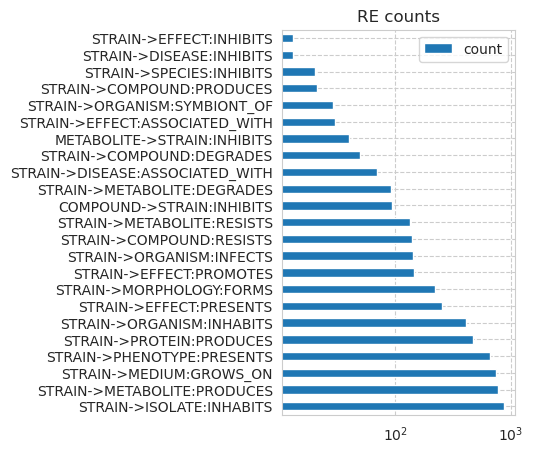

In [23]:
cnts[(cnts[0].str.contains("STRAIN"))&(cnts["count"]>12)].set_index(0).plot(kind='barh',figsize=(3,5),logx=True)
plt.title("RE counts")
plt.ylabel("")

In [24]:
c = cnts.rename(columns={0:"relationship"})

In [25]:
c["re"] = c.relationship.str.split(":",expand=True)[1]
c["ner_re"] = c.relationship.str.split(":",expand=True)[0]

In [26]:
c["non_strain_ner"] = c.relationship.str.split(":", expand=True)[0].str.split("->").apply(lambda x: [elem for elem in x if elem != "STRAIN"])


In [27]:
c["relationship"] = c.relationship.str.replace("->", "-")
c["ner_re"] = c["ner_re"].str.replace("->", "-")

In [28]:
cs = c[c['non_strain_ner'].apply(lambda x: len(x) == 1)]


In [29]:
cs.set_index("re")[["ner_re", "count"]]

,ner_re,count
re,,
INHABITS,STRAIN-ISOLATE,879
PRODUCES,STRAIN-METABOLITE,780
GROWS_ON,STRAIN-MEDIUM,745
PRESENTS,STRAIN-PHENOTYPE,661
PRODUCES,STRAIN-PROTEIN,469
INHABITS,STRAIN-ORGANISM,410
PRESENTS,STRAIN-EFFECT,252
FORMS,STRAIN-MORPHOLOGY,220
PROMOTES,STRAIN-EFFECT,144


In [30]:
cs.set_index("re")[["ner_re", "count"]]

,ner_re,count
re,,
INHABITS,STRAIN-ISOLATE,879
PRODUCES,STRAIN-METABOLITE,780
GROWS_ON,STRAIN-MEDIUM,745
PRESENTS,STRAIN-PHENOTYPE,661
PRODUCES,STRAIN-PROTEIN,469
INHABITS,STRAIN-ORGANISM,410
PRESENTS,STRAIN-EFFECT,252
FORMS,STRAIN-MORPHOLOGY,220
PROMOTES,STRAIN-EFFECT,144


In [31]:
cs['non_strain_ner'] = cs['non_strain_ner'].explode()


/tmp/ipykernel_7131/975501423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs['non_strain_ner'] = cs['non_strain_ner'].explode()


In [32]:
cs_filter = cs[(cs["count"]>13)&(cs["non_strain_ner"]!="VIRUS")]

In [33]:
cs_filter

,relationship,count,re,ner_re,non_strain_ner
0,STRAIN-ISOLATE:INHABITS,879,INHABITS,STRAIN-ISOLATE,ISOLATE
1,STRAIN-METABOLITE:PRODUCES,780,PRODUCES,STRAIN-METABOLITE,METABOLITE
2,STRAIN-MEDIUM:GROWS_ON,745,GROWS_ON,STRAIN-MEDIUM,MEDIUM
3,STRAIN-PHENOTYPE:PRESENTS,661,PRESENTS,STRAIN-PHENOTYPE,PHENOTYPE
4,STRAIN-PROTEIN:PRODUCES,469,PRODUCES,STRAIN-PROTEIN,PROTEIN
5,STRAIN-ORGANISM:INHABITS,410,INHABITS,STRAIN-ORGANISM,ORGANISM
6,STRAIN-EFFECT:PRESENTS,252,PRESENTS,STRAIN-EFFECT,EFFECT
7,STRAIN-MORPHOLOGY:FORMS,220,FORMS,STRAIN-MORPHOLOGY,MORPHOLOGY
8,STRAIN-EFFECT:PROMOTES,144,PROMOTES,STRAIN-EFFECT,EFFECT
9,STRAIN-ORGANISM:INFECTS,143,INFECTS,STRAIN-ORGANISM,ORGANISM


In [34]:
pivot_df = cs_filter.pivot_table(index='re', columns='non_strain_ner', values='count', aggfunc='sum').fillna(0)


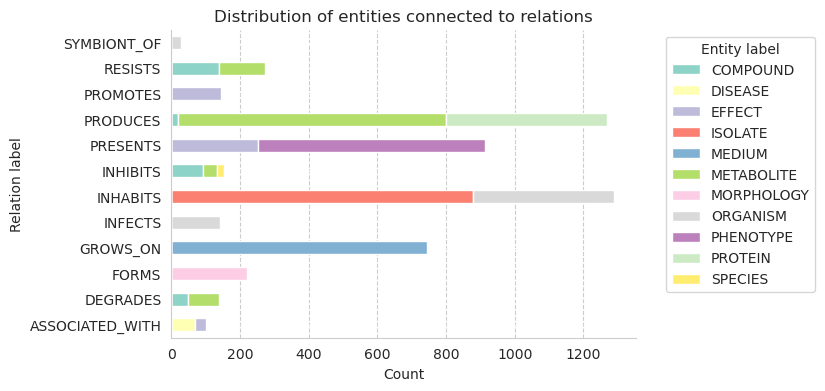

In [35]:
pivot_df.plot(kind='barh', stacked=True, colormap='Set3', figsize=(6, 4))

plt.xlabel('Count')
plt.ylabel('Relation label')
plt.title('Distribution of entities connected to relations')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Entity label")

# Remove horizontal axis lines in the background
plt.grid(axis='y', which='both', color='white')

# Remove the right spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.savefig("./figures/predictions/relationship_distribution.pdf", bbox_inches='tight')

In [ ]:
k